In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torch torchvision timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and DataLoader setup
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/trainset', transform=train_transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/testset', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup using Swin Transformer Small
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=True).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and evaluation
num_epochs = 10
train_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    val_accuracies.append(accuracy)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Accuracy: {accuracy:.2f}, '
          f'F1 Score: {f1:.2f}, '
          f'Precision: {precision:.2f}, '
          f'Recall: {recall:.2f}')

# Save the trained model
torch.save(model.state_dict(), 'swin_s_model.pth')

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
plt.plot(range(1, num_epochs+1), val_f1_scores, label='F1 Score', color='red')
plt.plot(range(1, num_epochs+1), val_precisions, label='Precision', color='purple')
plt.plot(range(1, num_epochs+1), val_recalls, label='Recall', color='orange')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.tight_layout()
plt.show()


Epoch [1/10], Train Loss: 0.4303, Val Accuracy: 0.96, F1 Score: 0.96, Precision: 0.97, Recall: 0.96
Epoch [2/10], Train Loss: 0.0450, Val Accuracy: 0.97, F1 Score: 0.97, Precision: 0.98, Recall: 0.97
Epoch [3/10], Train Loss: 0.0338, Val Accuracy: 0.99, F1 Score: 0.99, Precision: 0.99, Recall: 0.99
Epoch [4/10], Train Loss: 0.0148, Val Accuracy: 1.00, F1 Score: 1.00, Precision: 1.00, Recall: 1.00


KeyboardInterrupt: 

Epoch [1/5], Train Loss: 0.5031, Train Accuracy: 82.22%, Validation Accuracy: 97.30%, F1 Score: 97.28%, Precision: 97.36%, Recall: 97.30%
Epoch [2/5], Train Loss: 0.0835, Train Accuracy: 97.33%, Validation Accuracy: 98.30%, F1 Score: 98.30%, Precision: 98.30%, Recall: 98.30%
Epoch [3/5], Train Loss: 0.0342, Train Accuracy: 98.92%, Validation Accuracy: 98.70%, F1 Score: 98.70%, Precision: 98.73%, Recall: 98.70%
Epoch [4/5], Train Loss: 0.0134, Train Accuracy: 99.67%, Validation Accuracy: 99.70%, F1 Score: 99.70%, Precision: 99.70%, Recall: 99.70%
Epoch [5/5], Train Loss: 0.0254, Train Accuracy: 99.22%, Validation Accuracy: 99.00%, F1 Score: 99.00%, Precision: 99.02%, Recall: 99.00%
Model saved to /content/drive/MyDrive/swin_s_model.pth


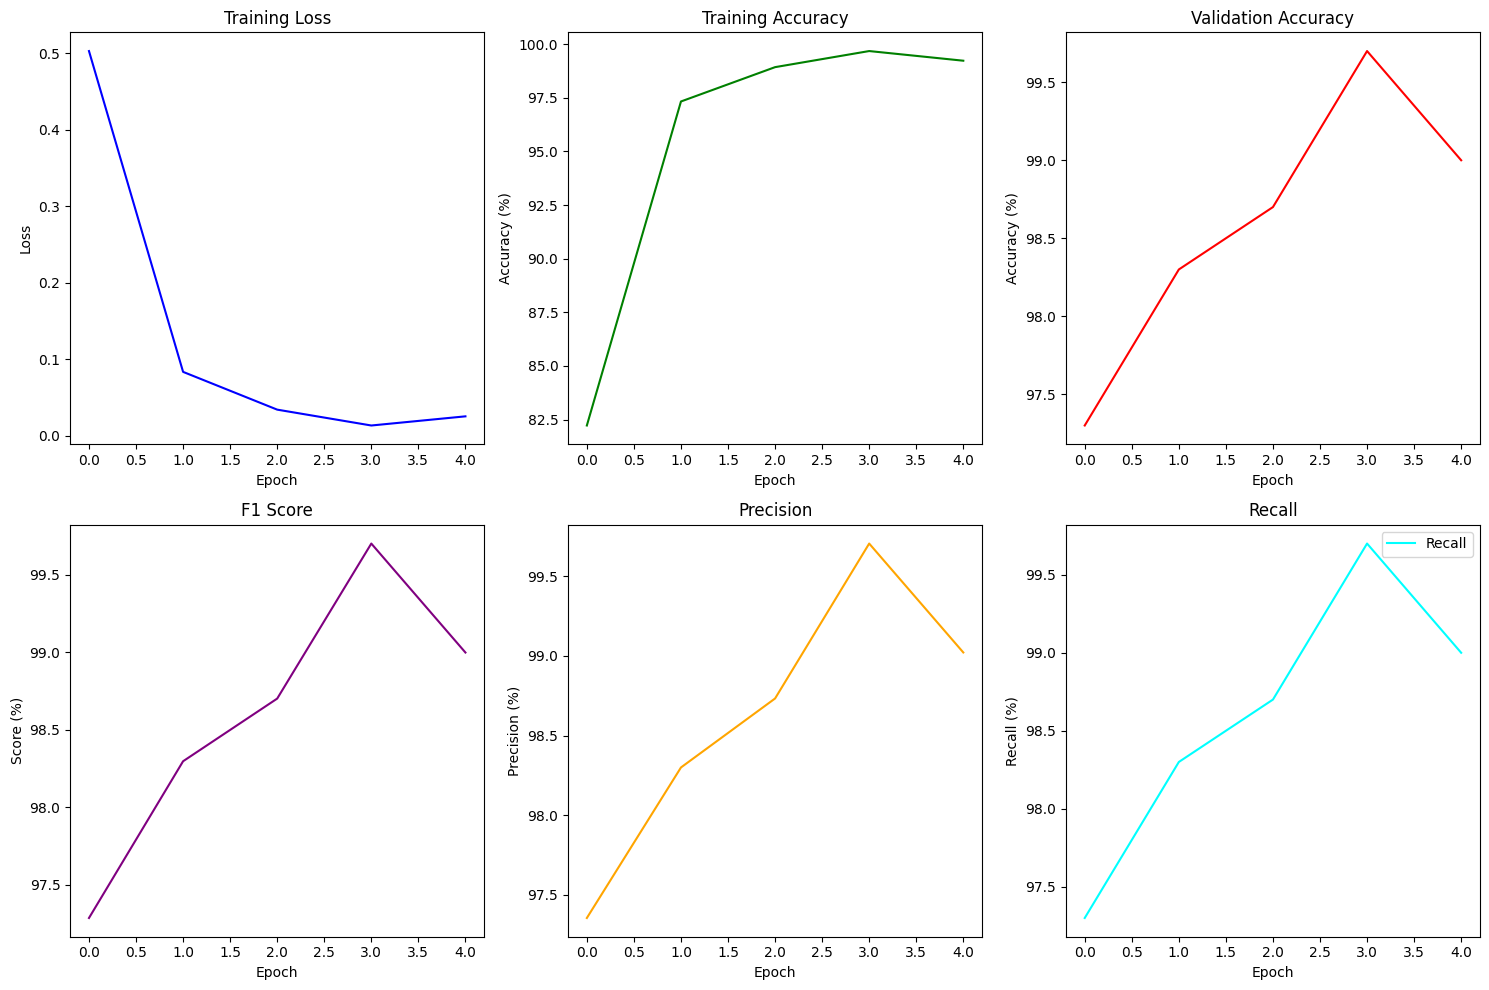

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and DataLoader setup
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/trainset', transform=train_transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/testset', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup using Swin Transformer Small
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=True).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and evaluation
num_epochs = 5
train_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='macro') * 100
    precision = precision_score(all_labels, all_preds, average='macro') * 100
    recall = recall_score(all_labels, all_preds, average='macro') * 100

    val_accuracies.append(val_accuracy)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Accuracy: {val_accuracy:.2f}%, '
          f'F1 Score: {f1:.2f}%, '
          f'Precision: {precision:.2f}%, '
          f'Recall: {recall:.2f}%')

# Save the trained model to drive
model_save_path = '/content/drive/MyDrive/swin_s_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Plotting
plt.figure(figsize=(15, 10))

# Plot training loss
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot training accuracy
plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

# Plot validation accuracy
plt.subplot(2, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

# Plot F1 Score
plt.subplot(2, 3, 4)
plt.plot(val_f1_scores, label='F1 Score', color='purple')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score (%)')

# Plot Precision
plt.subplot(2, 3, 5)
plt.plot(val_precisions, label='Precision', color='orange')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision (%)')

# Plot Recall
plt.subplot(2, 3, 6)
plt.plot(val_recalls, label='Recall', color='cyan')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall (%)')

plt.legend()
plt.tight_layout()
plt.show()


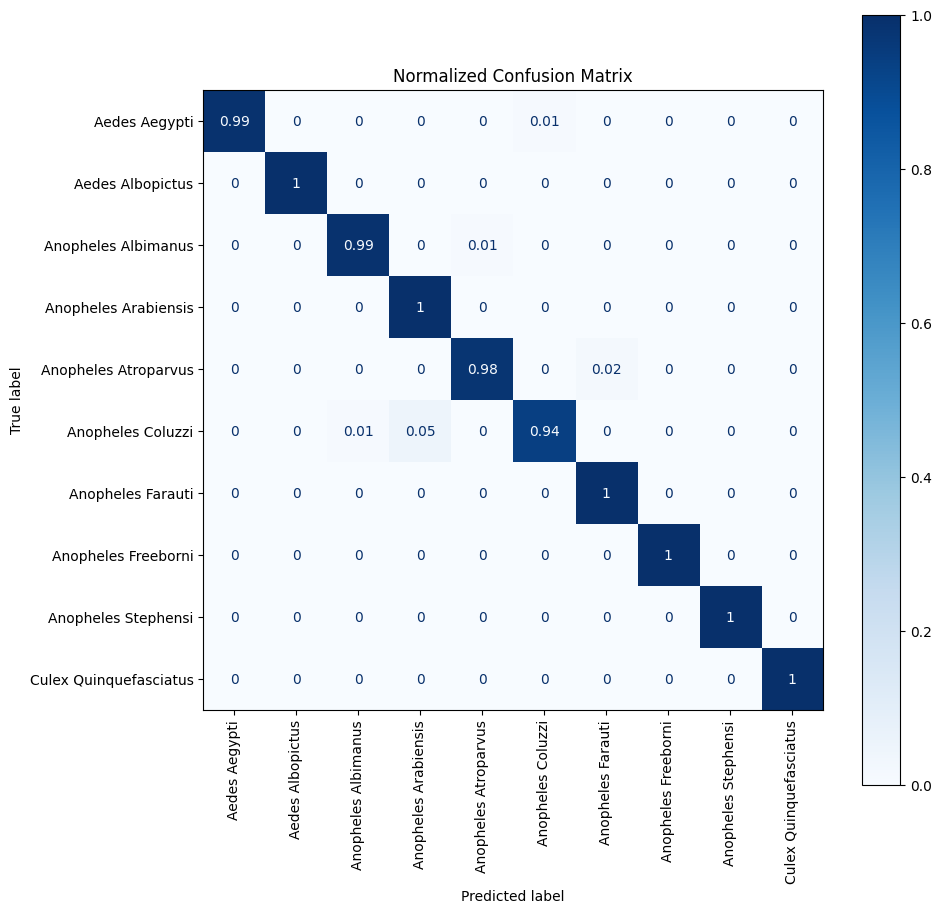

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming the completion of the training and validation phase
# and you have `all_labels` and `all_preds`

# Define class names manually based on your dataset
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Normalized Confusion Matrix')
plt.show()


Saving Aedes Aegypti_11.jpg to Aedes Aegypti_11.jpg


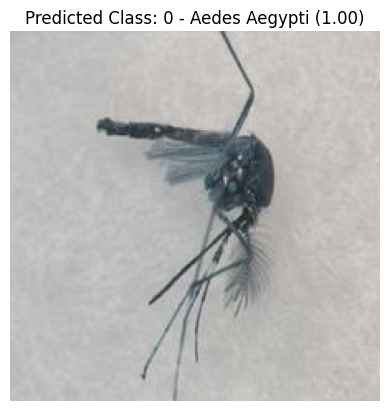

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Swin Transformer Small model
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


Saving 37s.jpg to 37s.jpg


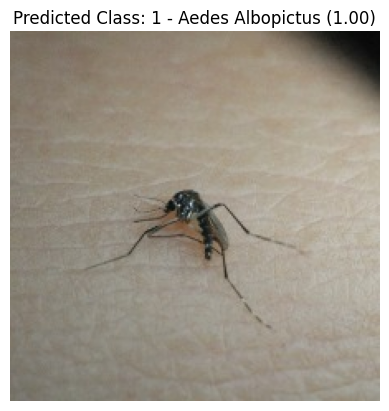

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Swin Transformer Small model
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


Saving Anopheles Albimanus_augmented_25.jpg to Anopheles Albimanus_augmented_25.jpg


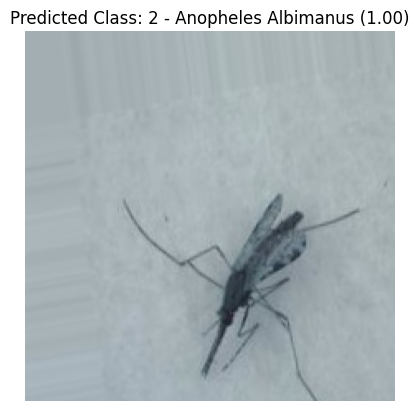

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Swin Transformer Small model
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


Saving Anopheles Arabiensis_augmented_77.jpg to Anopheles Arabiensis_augmented_77.jpg


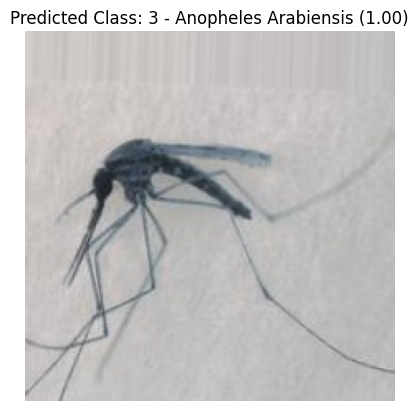

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Swin Transformer Small model
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


Saving Anopheles Atroparvus_augmented_36.jpg to Anopheles Atroparvus_augmented_36.jpg


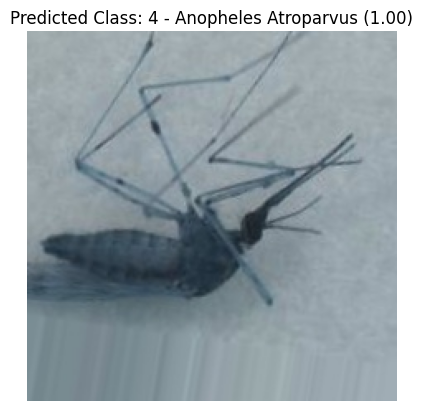

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Swin Transformer Small model
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


Saving Anopheles Coluzzi_augmented_70.jpg to Anopheles Coluzzi_augmented_70.jpg


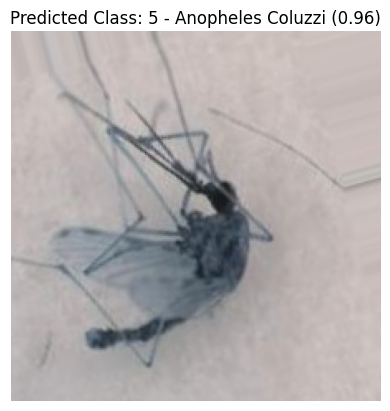

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Swin Transformer Small model
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


Saving Anopheles Farauti_augmented_26.jpg to Anopheles Farauti_augmented_26.jpg


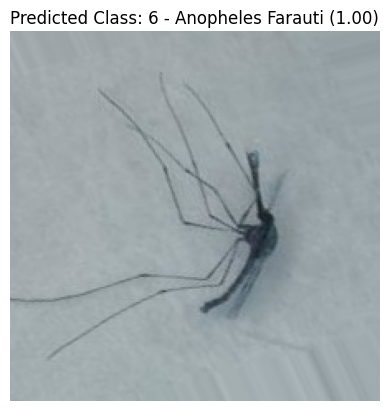

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Swin Transformer Small model
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


Saving Anopheles Freeborni_augmented_15.jpg to Anopheles Freeborni_augmented_15.jpg


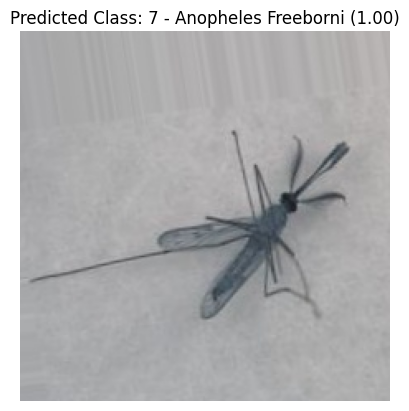

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Swin Transformer Small model
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


Saving Anopheles Stephensi_augmented_75.jpg to Anopheles Stephensi_augmented_75.jpg


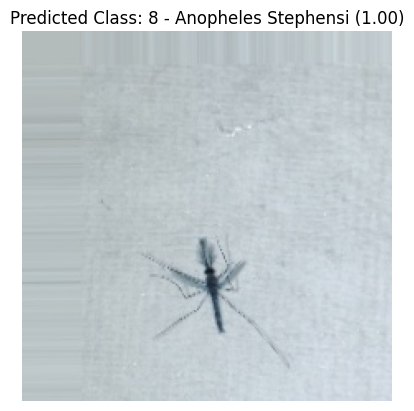

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Swin Transformer Small model
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


Saving 25s.jpg to 25s.jpg


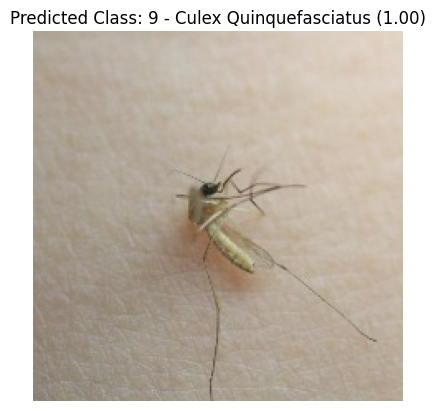

In [ ]:
import shutil
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Swin Transformer Small model
model = create_model('swin_small_patch4_window7_224', num_classes=10, pretrained=False)
model.load_state_dict(torch.load('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth', map_location=device))
model.to(device)
model.eval()

# Define the image dimensions
img_height, img_width = 224, 224

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    # Convert image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict class probabilities
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_prob, predicted_class_idx = torch.max(probabilities, dim=0)
        predicted_class = class_names[predicted_class_idx.item()]

    return predicted_class_idx.item(), predicted_class, predicted_prob.item()

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)

    # Predict image class
    prediction_index, prediction_name, prediction_prob = predict_image_class(img)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction_index} - {prediction_name} ({prediction_prob:.2f})')
    plt.show()


FileUpload(value={}, accept='image/*', description='Upload')

Recalibrated Scores:
Aedes Aegypti: 0.6506
Aedes Albopictus: 0.8955
Anopheles Albimanus: 0.9345
Anopheles Arabiensis: 0.9188
Anopheles Atroparvus: 0.9591
Anopheles Coluzzi: 0.9436
Anopheles Farauti: 0.9811
Anopheles Freeborni: 0.8888
Anopheles Stephensi: 0.9503
Culex Quinquefasciatus: 0.8777


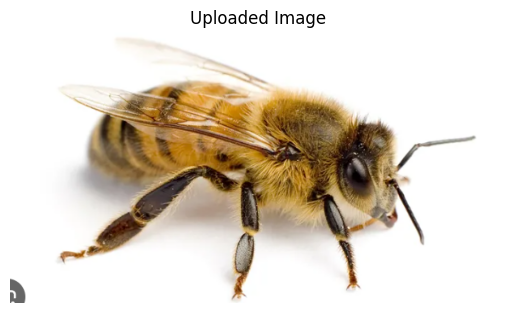

Predicted Class: Unknown
Recalibrated Scores:
Aedes Aegypti: 0.8389
Aedes Albopictus: 0.8262
Anopheles Albimanus: 0.8855
Anopheles Arabiensis: 0.9369
Anopheles Atroparvus: 0.9089
Anopheles Coluzzi: 0.9519
Anopheles Farauti: 0.9472
Anopheles Freeborni: 0.7875
Anopheles Stephensi: 0.9658
Culex Quinquefasciatus: 0.9513


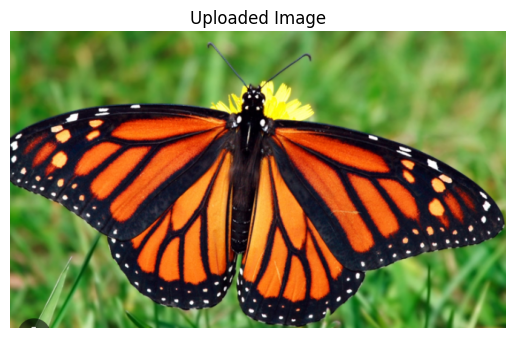

Predicted Class: Unknown
Recalibrated Scores:
Aedes Aegypti: 0.0000
Aedes Albopictus: 1.0000
Anopheles Albimanus: 1.0000
Anopheles Arabiensis: 1.0000
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 1.0000
Anopheles Freeborni: 1.0000
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 1.0000


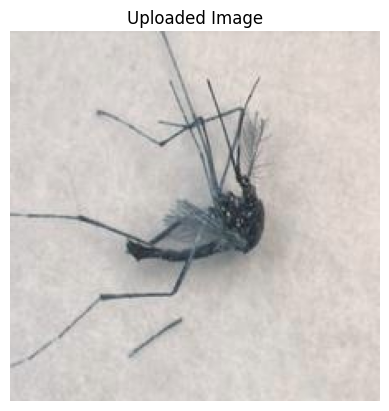

Predicted Class: Aedes Aegypti
Recalibrated Scores:
Aedes Aegypti: 1.0000
Aedes Albopictus: 1.0000
Anopheles Albimanus: 0.9996
Anopheles Arabiensis: 1.0000
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 1.0000
Anopheles Freeborni: 1.0000
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.0005


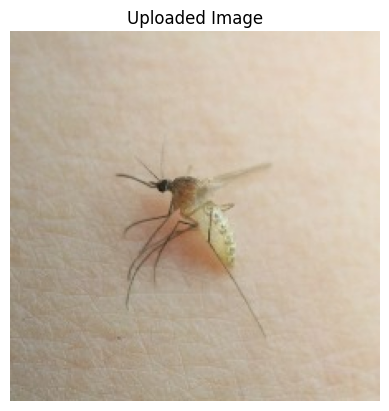

Predicted Class: Culex Quinquefasciatus


In [ ]:
import numpy as np
import torch
from torchvision import transforms
from timm import create_model
from scipy.special import softmax
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
import io
from PIL import Image

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Load the trained Swin Transformer Base model
model_path = '/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth'
model = create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=len(class_names))
model.load_state_dict(torch.load(model_path))
model.eval()

# Define the image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def openmax_single_image(img):
    # Preprocess the image
    img_tensor = preprocess(img).unsqueeze(0)

    # Get model's prediction
    with torch.no_grad():
        prediction = model(img_tensor)

    # Implement OpenMax here...
    # For simplicity, let's assume OpenMax recalibration as inverse of the normalized softmax
    softmax_scores = softmax(prediction.numpy()[0])
    normalized_scores = softmax_scores / np.sum(softmax_scores)
    recalibrated_scores = 1 - normalized_scores

    # Threshold for unknown class
    unknown_threshold = 0.7  # Adjust as needed

    # If the maximum score is below the unknown threshold, classify as "Unknown"
    if np.max(softmax_scores) < unknown_threshold:
        result = "Unknown"
    else:
        result = class_names[np.argmax(softmax_scores)]

    print("Recalibrated Scores:")
    for i, score in enumerate(recalibrated_scores):
        print(f"{class_names[i]}: {score:.4f}")

    return result, recalibrated_scores

# Create an image uploader
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def on_upload_change(change):
    # When file is uploaded, get the image data and call openmax_single_image
    uploaded_filename = next(iter(uploader.value))
    content = uploader.value[uploaded_filename]['content']

    # Load the uploaded image
    img = Image.open(io.BytesIO(content)).convert('RGB')

    # Call openmax_single_image function
    result, recalibrated_scores = openmax_single_image(img)

    # Display the uploaded image
    plt.imshow(img)
    plt.axis('off')
    plt.title('Uploaded Image')
    plt.show()

    # Display result
    print("Predicted Class:", result)

uploader.observe(on_upload_change, names='_counter')


True openmax implementation



In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Correct number of classes based on the model's original training configuration
num_classes = 10  # Make sure this matches your actual number of classes

# Load the Swin Transformer model
model = timm.create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=num_classes)
model_path = '/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = ImageFolder(root='/content/drive/MyDrive/datasets/trainset', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Extract logits and labels from the training data
logits = []
labels = []
with torch.no_grad():
    for images, label in dataloader:
        images = images.to(device)
        outputs = model(images)
        logits.append(outputs.cpu().numpy().flatten())
        labels.append(label.item())

logits = np.array(logits)
labels = np.array(labels)

# Calculate MAVs and distances for each class
mavs = []
distances = []
for i in range(num_classes):
    class_indices = np.where(labels == i)[0]
    class_logits = logits[class_indices]
    mav = np.mean(class_logits, axis=0)
    mavs.append(mav)
    dist = euclidean_distances([mav], class_logits)
    distances.append(dist.flatten())

# Fit Weibull distribution for each class
weibull_models = []
for dist in distances:
    params = weibull_min.fit(dist, floc=0)
    weibull_models.append(params)

# Save the MAVs and Weibull models
with open('swin_s_mavs_and_weibull.pkl', 'wb') as f:
    pickle.dump((mavs, weibull_models), f)

print("MAVs and Weibull models are ready for prediction.")


Using device: cuda
MAVs and Weibull models are ready for prediction.


IndexError: list index out of range

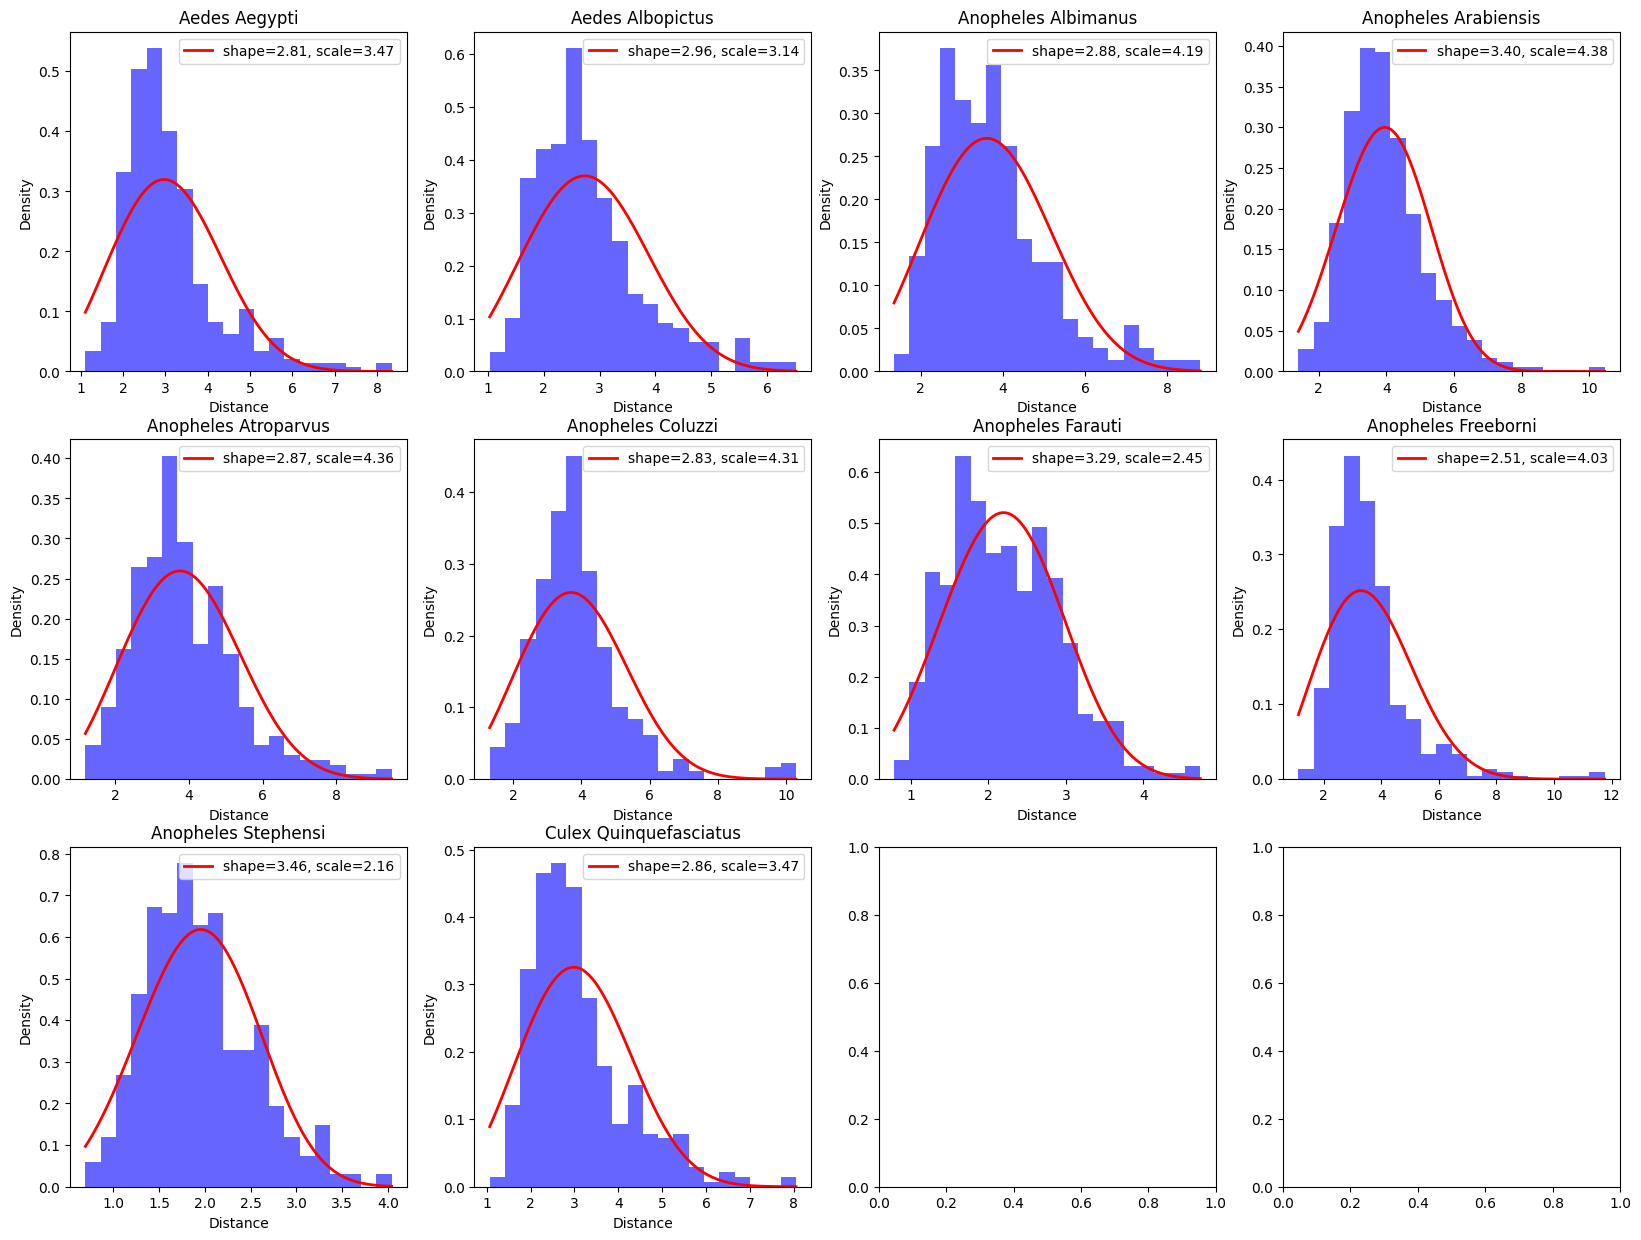

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import weibull_min

# Assuming `distances` and `weibull_models` are already computed as per the previous discussion
# `distances` is a list of arrays, each containing the distances for a class
# `weibull_models` contains the fitted parameters (shape, loc, scale) for each class

class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']  # Ensure class names are defined

# Plot the Weibull distribution fits
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.ravel()

for i in range(len(class_names)):
    ax = axes[i]
    dist = distances[i]
    params = weibull_models[i]
    shape, loc, scale = params

    # Generate Weibull distribution for given parameters
    x = np.linspace(min(dist), max(dist), 100)
    y = weibull_min.pdf(x, shape, loc, scale)

    # Plotting the histogram of distances and the PDF of the fitted Weibull distribution
    ax.hist(dist, bins=20, density=True, alpha=0.6, color='b')
    ax.plot(x, y, 'r-', lw=2, label=f'shape={shape:.2f}, scale={scale:.2f}')
    ax.set_title(class_names[i])
    ax.set_xlabel('Distance')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()


openmax using threshold 0.5

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Swin Transformer Small model
model = timm.create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/swin_s_mavs_and_weibull.pkl', 'rb') as f:  # Ensure correct file name
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.5  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda
Accuracy: 0.5818181818181818
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       1.00      0.53      0.69       100
      Aedes Albopictus       1.00      0.62      0.77       100
   Anopheles Albimanus       1.00      0.55      0.71       100
  Anopheles Arabiensis       1.00      0.45      0.62       100
  Anopheles Atroparvus       1.00      0.58      0.73       100
     Anopheles Coluzzi       1.00      0.39      0.56       100
     Anopheles Farauti       1.00      0.53      0.69       100
   Anopheles Freeborni       1.00      0.61      0.76       100
   Anopheles Stephensi       1.00      0.49      0.66       100
Culex Quinquefasciatus       1.00      0.65      0.79       100
               Unknown       0.18      1.00      0.30       100

              accuracy                           0.58      1100
             macro avg       0.93      0.58      0.66      1100
          weighted avg       0

openmax using threshold 0.4

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Swin Transformer Small model
model = timm.create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/swin_s_mavs_and_weibull.pkl', 'rb') as f:  # Ensure correct file name
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.4  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda
Accuracy: 0.6818181818181818
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       1.00      0.65      0.79       100
      Aedes Albopictus       1.00      0.70      0.82       100
   Anopheles Albimanus       1.00      0.65      0.79       100
  Anopheles Arabiensis       1.00      0.55      0.71       100
  Anopheles Atroparvus       1.00      0.70      0.82       100
     Anopheles Coluzzi       1.00      0.55      0.71       100
     Anopheles Farauti       1.00      0.59      0.74       100
   Anopheles Freeborni       1.00      0.73      0.84       100
   Anopheles Stephensi       1.00      0.63      0.77       100
Culex Quinquefasciatus       1.00      0.75      0.86       100
               Unknown       0.22      1.00      0.36       100

              accuracy                           0.68      1100
             macro avg       0.93      0.68      0.75      1100
          weighted avg       0

openmax using threshold 0.3

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Swin Transformer Small model
model = timm.create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/swin_s_mavs_and_weibull.pkl', 'rb') as f:  # Ensure correct file name
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.3  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda
Accuracy: 0.76
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       1.00      0.73      0.84       100
      Aedes Albopictus       1.00      0.79      0.88       100
   Anopheles Albimanus       1.00      0.71      0.83       100
  Anopheles Arabiensis       1.00      0.72      0.84       100
  Anopheles Atroparvus       1.00      0.75      0.86       100
     Anopheles Coluzzi       1.00      0.64      0.78       100
     Anopheles Farauti       1.00      0.69      0.82       100
   Anopheles Freeborni       1.00      0.79      0.88       100
   Anopheles Stephensi       1.00      0.70      0.82       100
Culex Quinquefasciatus       1.00      0.84      0.91       100
               Unknown       0.27      1.00      0.43       100

              accuracy                           0.76      1100
             macro avg       0.93      0.76      0.81      1100
          weighted avg       0.93      0.76 

openmax using threshold 0.2

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Swin Transformer Small model
model = timm.create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/swin_s_mavs_and_weibull.pkl', 'rb') as f:  # Ensure correct file name
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.2  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda
Accuracy: 0.8263636363636364
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       1.00      0.80      0.89       100
      Aedes Albopictus       1.00      0.84      0.91       100
   Anopheles Albimanus       1.00      0.79      0.88       100
  Anopheles Arabiensis       1.00      0.76      0.86       100
  Anopheles Atroparvus       1.00      0.84      0.91       100
     Anopheles Coluzzi       1.00      0.74      0.85       100
     Anopheles Farauti       1.00      0.75      0.86       100
   Anopheles Freeborni       1.00      0.87      0.93       100
   Anopheles Stephensi       1.00      0.80      0.89       100
Culex Quinquefasciatus       1.00      0.90      0.95       100
               Unknown       0.34      1.00      0.51       100

              accuracy                           0.83      1100
             macro avg       0.94      0.83      0.86      1100
          weighted avg       0

openmax using threshold 0.1

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Swin Transformer Small model
model = timm.create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/swin_s_mavs_and_weibull.pkl', 'rb') as f:  # Ensure correct file name
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.1  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda
Accuracy: 0.8863636363636364
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       1.00      0.88      0.94       100
      Aedes Albopictus       1.00      0.90      0.95       100
   Anopheles Albimanus       1.00      0.85      0.92       100
  Anopheles Arabiensis       1.00      0.84      0.91       100
  Anopheles Atroparvus       1.00      0.89      0.94       100
     Anopheles Coluzzi       1.00      0.84      0.91       100
     Anopheles Farauti       1.00      0.82      0.90       100
   Anopheles Freeborni       1.00      0.92      0.96       100
   Anopheles Stephensi       1.00      0.85      0.92       100
Culex Quinquefasciatus       1.00      0.96      0.98       100
               Unknown       0.44      1.00      0.62       100

              accuracy                           0.89      1100
             macro avg       0.95      0.89      0.90      1100
          weighted avg       0

Using device: cuda


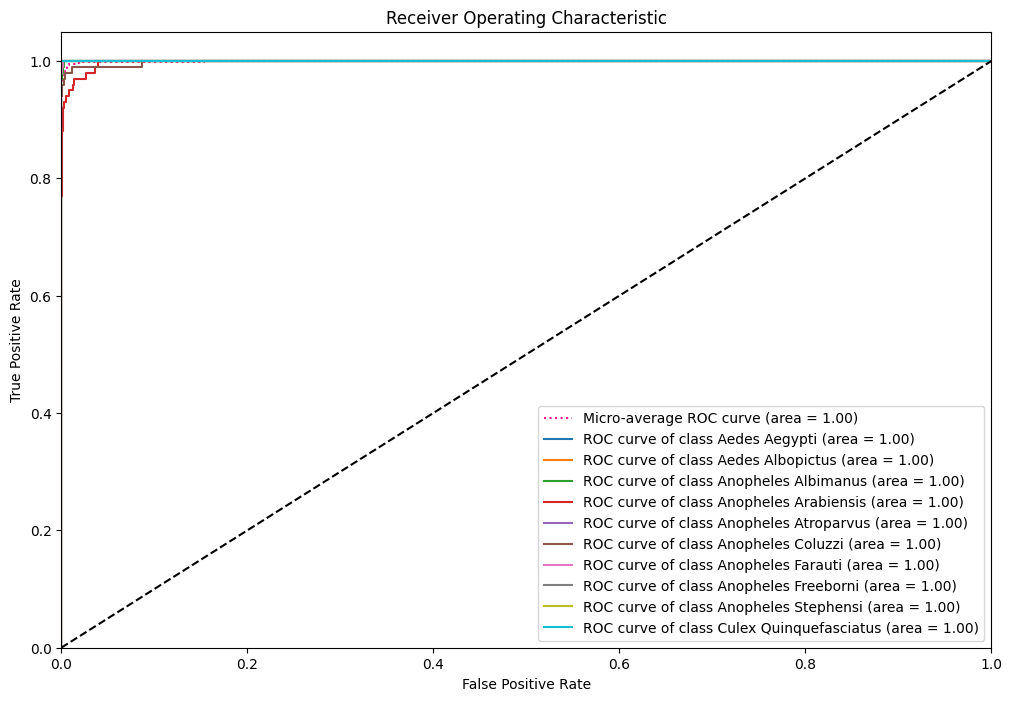

AUROC per class:
Aedes Aegypti: 1.00
Aedes Albopictus: 1.00
Anopheles Albimanus: 1.00
Anopheles Arabiensis: 1.00
Anopheles Atroparvus: 1.00
Anopheles Coluzzi: 1.00
Anopheles Farauti: 1.00
Anopheles Freeborni: 1.00
Anopheles Stephensi: 1.00
Culex Quinquefasciatus: 1.00
Micro-average AUROC: 0.9996041000000001


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import timm

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Swin Transformer Small model
model = timm.create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Prepare label binarizer
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']
n_classes = len(class_names)

# Collect all scores and true labels
true_labels = []
scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy()
        scores.extend(outputs)
        true_labels.extend(labels.numpy())

# Binarize the labels for ROC calculation
true_labels = label_binarize(true_labels, classes=range(n_classes))
scores = np.array(scores)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUROC scores
print("AUROC per class:")
for i, name in enumerate(class_names):
    print(f"{name}: {roc_auc[i]:.2f}")
print("Micro-average AUROC:", roc_auc["micro"])


Using device: cuda


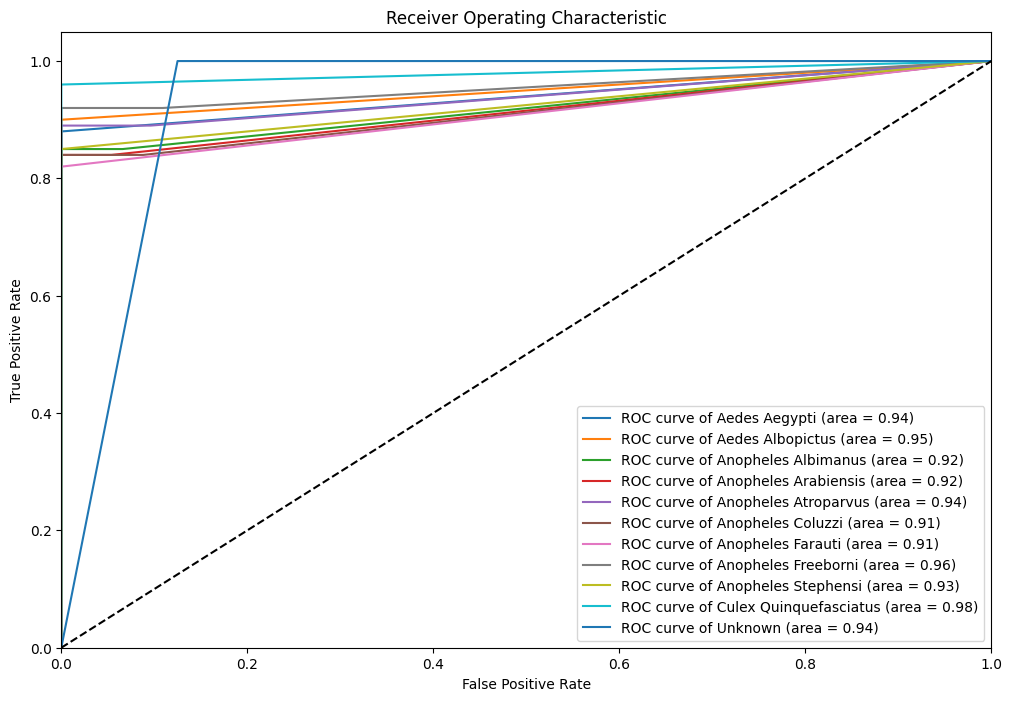

AUROC per class:
Aedes Aegypti: 0.94
Aedes Albopictus: 0.95
Anopheles Albimanus: 0.92
Anopheles Arabiensis: 0.92
Anopheles Atroparvus: 0.94
Anopheles Coluzzi: 0.91
Anopheles Farauti: 0.91
Anopheles Freeborni: 0.96
Anopheles Stephensi: 0.93
Culex Quinquefasciatus: 0.98
Unknown: 0.94


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pickle
import timm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Swin Transformer model
model = timm.create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/content/drive/MyDrive/datasets/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/content/swin_s_mavs_and_weibull.pkl', 'rb') as f:  # Updated file name for Swin-S model
    mavs, weibull_models = pickle.load(f)

# Prepare for ROC
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']
n_classes = len(class_names) - 1  # excluding the 'Unknown' for initial setup

true_labels = []
scores = []

# Adjust logits using OpenMax
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images).cpu().numpy()
        adjusted_scores = np.zeros((logits.shape[0], n_classes + 1))  # +1 for unknown

        for i, logit in enumerate(logits):
            recalibrated_scores = np.zeros(n_classes)
            for j in range(n_classes):
                dist = euclidean_distances([logit], [mavs[j]])[0][0]
                shape, loc, scale = weibull_models[j]
                weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
                recalibrated_scores[j] = 1 - weibull_cdf

            if max(recalibrated_scores) < 0.1:  # Threshold for 'Unknown'
                adjusted_scores[i, -1] = 1  # Set last class (Unknown) score to 1
            else:
                adjusted_scores[i, :-1] = recalibrated_scores

            scores.append(adjusted_scores[i])
            true_labels.append(labels.numpy()[i])

scores = np.array(scores)
true_labels = label_binarize(true_labels, classes=range(n_classes + 1))

# Compute ROC and AUROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes + 1):  # Including 'Unknown'
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(12, 8))
for i in range(n_classes + 1):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUROC
print("AUROC per class:")
for i in range(n_classes + 1):
    print(f"{class_names[i]}: {roc_auc[i]:.2f}")


Using device: cuda


FileUpload(value={}, accept='image/*', description='Upload')

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


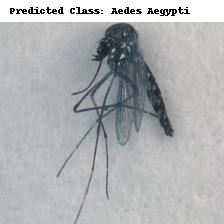

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


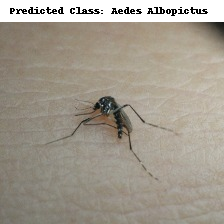

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


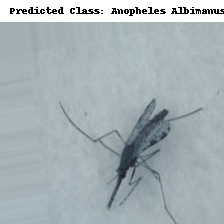

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


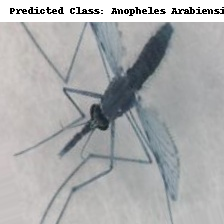

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


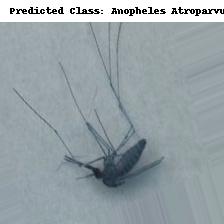

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


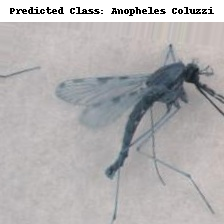

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


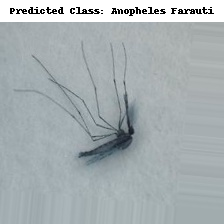

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


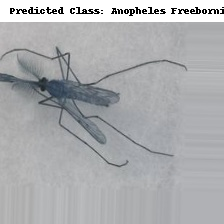

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


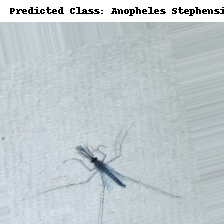

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


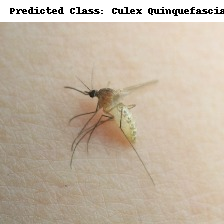

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


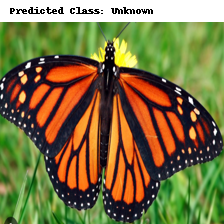

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


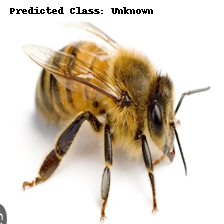

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


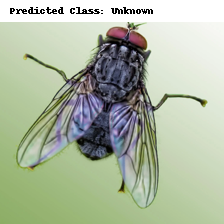

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


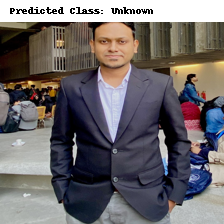

<ipython-input-21-9f0401a9c957>:65: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


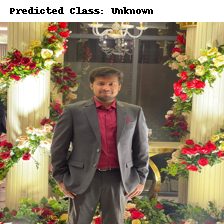

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances
import pickle
import timm
from PIL import Image, ImageDraw, ImageFont
import ipywidgets as widgets
from IPython.display import display

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the Swin Transformer Small model
model = timm.create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=10)
model_path = '/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# Load MAVs and Weibull models
with open('/content/drive/MyDrive/mosquito_model5(Swin-S)/swin_s_mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']
num_classes = len(class_names)

def classify_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img_tensor).cpu().numpy().flatten()

    # Calculate distances from MAVs and apply Weibull CDF
    recalibrated_scores = np.zeros(num_classes)
    for i in range(num_classes):
        dist = euclidean_distances([logits], [mavs[i]])[0][0]
        shape, loc, scale = weibull_models[i]
        weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
        recalibrated_scores[i] = 1 - weibull_cdf

    # Apply threshold to determine if the image is unknown or one of the known classes
    threshold = 0.1
    predicted_class_index = np.argmax(recalibrated_scores)
    predicted_class = "Unknown" if recalibrated_scores[predicted_class_index] < threshold else class_names[predicted_class_index]

    # Draw predicted class on the image
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    text = f'Predicted Class: {predicted_class}'
    text_width, text_height = draw.textsize(text, font=font)
    img_width, img_height = img.size
    draw.rectangle([(0, 0), (img_width, text_height + 10)], fill='white')
    draw.text((10, 5), text, fill='black', font=font)

    # Display the image with the predicted class overlaid
    display(img)

# Widget to upload an image
uploader = widgets.FileUpload(
    accept='image/*',  # Accept only images
    multiple=False  # Allow single file upload
)

def on_upload_change(change):
    if not uploader.value:
        return
    for _, file_info in uploader.value.items():
        content = file_info['content']
        with open("uploaded_image.png", "wb") as f:
            f.write(content)
        classify_image("uploaded_image.png")

uploader.observe(on_upload_change, names='value')
display(uploader)
